# 4. Practical part: Density estimation

IFT 6390 Fall/Automne 2018, HW1, Q4, practical

Arlie Coles (20121051) & Violet Guo ()

*Note to TAs: these implementations run on Python 3.*

## 1. Implementation of a Gaussian parametric density estimator

In [123]:
import numpy as np
import math

class gaussianDiag:
    def __init__(self, data):
        self.train_data = data
        self.train_mean = 0
        self.train_cov = 0
        self.train_std = 0
        
        # Hack to get dimension, since input can be confusing:
        #   ex. test_data = [1, 2, 3] is 1D data, not 3D!
        #   but test_data = [[1,2], [2,3], [3,4]] would be 2D data, with 3 data points.
        if isinstance(self.train_data[0], np.float64) or isinstance(self.train_data[0], int):
            self.dim_d = 1
        else:
            self.dim_d = len(self.train_data[0])
    
    def train_diag(self):
        '''
        Calculate the mean and generate the covariance matrix
        '''
        
        # Get the mean
        self.train_mean = np.mean(self.train_data, axis = 0)
        
        # Get the covariance matrix
        #   We don't have to worry about "making it diagonal" here:
        #   when we predict, we will just do the operations on the diagonal parts of the cov matrix,
        #   effectively treating all other entries as zero.
        self.train_cov = np.cov(self.train_data)  
        

    def predict_diag(self, test_data):
        '''
        Calculate the const = 1/(2 pi sigma^2 sqrt(det(cov))
        then, sample each point's density ~ 1/sigma^2 (x_i - \mu)^2
        finally, take the negative log
        '''
        
        # Hack to accomodate 1D data: the determinant of a 1x1 matrix is just that entry.
        if self.dim_d == 1:
            det = self.train_cov
        else:
            # The determinant of a diagonal matrix is the product along the diagonal,
            #   and we are taking everything except the diagonal to be zero
            det = self.train_cov.diagonal().prod()
            
        # Calculate the constant (normalizing) term
        const_term = 1.0/np.multiply((2*math.pi)**(float(self.dim_d)/2.0), np.sqrt(det))

        # Calculate the sum part of the exponent
        sum = 0
        if self.dim_d == 1: # Hack for 1D data: no need to index in, since these "matrices" are 1x1
            sum = (1.0/self.train_cov) * (test_data - self.train_mean)**2
        else:
            for i in range(self.dim_d-1):
                sum += (1.0/self.train_cov[i,i]) * (test_data[i] - self.train_mean[i])**2
                
        # Construct the e^() term        
        exp_term = math.e**(-0.5 * sum)
        
        # Finally, calculate the log density
        density = math.log(const_term * exp_term)
        return density

We test the Gaussian estimator with some dummy data:

In [124]:
data = np.array([[10 ,11,12], [13,10,8]])
test_point = np.array([5,8,10])

part2 = gaussianDiag(data)
part2.train_diag()
print(part2.predict_diag(test_point))

-25.29814999749476


## 2.  Implementation of a Parzen density estimator

In [125]:
class parzenEstimator:
    def __init__(self, data, kernel_stdev):
        self.train_data = data
        self.kernel_stdev = kernel_stdev
        if isinstance(self.train_data[0], np.float64) or isinstance(self.train_data[0], int):
            self.d = 1
        else:
            self.d = len(self.train_data[0])
        
    def train(self, train_data):
        # Loading datapoints was taken care of in the constructor above.
        # This function creates the lambda function that makes summing easier/faster in the predict() function.
        # This metaphorically "creates" a Gaussian centered on each datapoint, while leaving the slot in the pdf for
        #  the test point open, until the weighting actually occurs at test time.
        
        norm_const = 1.0/np.multiply((2*math.pi)**(self.d/2), self.kernel_stdev**self.d)
        self.summand = lambda x, mu : np.multiply(norm_const, np.exp(np.multiply(-0.5, ((np.linalg.norm(x - mu))/(self.kernel_stdev**2)))))

    def predict(self, test_point):
        # Sum over the kernels with the datapoint as x
        density = 0
        for datapoint in self.train_data:
            density += self.summand(test_point, datapoint)
        log_density = np.log(density)
        return log_density

We test the Parzen estimator with some dummy data:

In [126]:
data = np.array([[2 ,2,3], [2,2,2]])
test_point = np.array([1,2,3])

part2 = parzenEstimator(data, 0.5)
part2.train(data)
print(part2.predict(test_point))

-2.315000408525107


## 3. 1D densities

First, let's open and parse the Iris dataset, selecting just the versicolor class:

In [127]:
with open('iris.data', 'r') as fp:
    iris_data = fp.readlines()

# Get just the versicolor class
versicolor_lines = []
for line in iris_data:
    if 'versicolor' in line:
        versicolor_lines.append(line.strip())

Then, let's further select just the data for sepal length:

In [128]:
data_1d = []
for line in versicolor_lines:
    data_1d.append(float(line.split(',')[0]))
data_1d.sort()
data_1d = np.array(data_1d)

### Part (a)

A plot of the data points of the subset:

### Part (b)

A plot of the density estimated by the Gaussian estimator:

In [129]:
# Instantiate and train the estimator
oneD_param = gaussianDiag(data_1d)
oneD_param.train_diag()

def gaussian_full_density(data_1d):
    density_points = []
    for datapoint in data_1d:
        # Calculate the density at each point
        density_points.append(oneD_param.predict_diag(datapoint))
    return np.array(density_points)

density_points_gaussian = gaussian_full_density(data_1d)



### Part (c)

Calculating the density estimated by the Parzen estimator, with a $\sigma$ that is too small:

In [130]:
# The entire density curve here consists of each p(x) for all x in the data,
# calculated by using (all the dataset - x) as the training data,
# and x as the test data.

stdev = 0.1

def parzen_full_density(data_1d, stdev):
    density_points = []
    for datapoint in data_1d:
        # First get a list of all the data - the test point
        for i, train_datapoint in enumerate(data_1d):
            if np.array_equal(datapoint, train_datapoint): #datapoint == train_datapoint:
                train_data = np.delete(data_1d, i)
                break

        # Then calculate the weights of all the other points relative to the test point
        estimator = parzenEstimator(train_data, stdev)
        estimator.train(train_data)
        density_points.append(estimator.predict(datapoint))
    return np.array(density_points)

density_points_small = parzen_full_density(data_1d, stdev)

### Part (d)

Calculating the density estimated by the Parzen estimator, with a $\sigma$ that is too big:

In [131]:
stdev = 1

density_points_big = parzen_full_density(data_1d, stdev)

### Part (e)

A plot of the density estimated by the Parzen estimator, after also calculating the density with a $\sigma$ that is an appropriate size:

In [132]:
stdev = .3
density_points_good = parzen_full_density(data_1d, stdev)




[4.9 5.  5.  5.1 5.2 5.4 5.5 5.5 5.5 5.5 5.5 5.6 5.6 5.6 5.6 5.6 5.7 5.7
 5.7 5.7 5.7 5.8 5.8 5.8 5.9 5.9 6.  6.  6.  6.  6.1 6.1 6.1 6.1 6.2 6.2
 6.3 6.3 6.3 6.4 6.4 6.5 6.6 6.6 6.7 6.7 6.7 6.8 6.9 7. ]


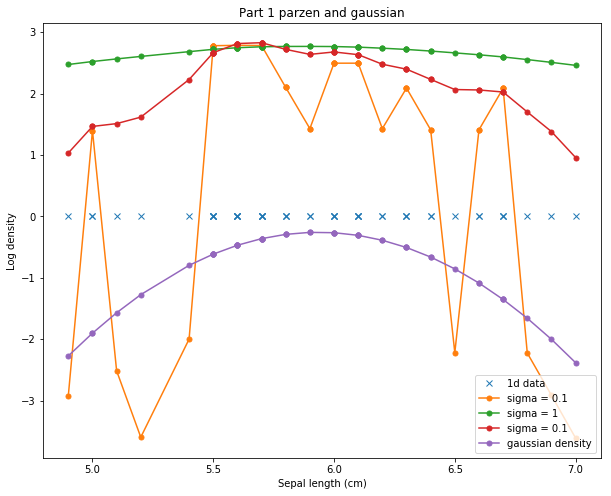

In [142]:
import matplotlib.pyplot as plt
# Make plots bigger
plt.rcParams['figure.figsize'] = [10, 8]

print(data_1d)
plt.plot(data_1d, np.zeros_like(data_1d) + 0., 'x', label = "1d data")

#plt.yticks([])



plt.plot(data_1d, density_points_small, marker="o", ms=5, label="sigma = 0.1".format(stdev))
plt.plot(data_1d, density_points_big, marker="o", ms=5, label="sigma = 1")
plt.plot(data_1d, density_points_good, marker="o", ms=5, label="sigma = {}".format(stdev))

# Plot the result
plt.plot(data_1d, density_points_gaussian, marker="o", ms=5, label ="diagonalgaussian")

plt.legend(loc='lower right')
plt.xlabel('Sepal length (cm)')
plt.ylabel('Log density')
plt.title('Part 1 parzen and gaussian')
plt.show()


### Part (f)

The hyperparamter $\sigma$ was "tuned" by hand, after a strategy modelled on binary search (i.e. test a midpoint between the two extremes, choosing the best half's endpoints as the new extremes until a satisfactory value was found). 0.3 seems to be an acceptable value because it strikes a balance between modelling where datapoints tend to concentrate while not overfitting and memorizing noise of our very limited dataset.

## 4. 2D densities

First, let's get the sepal length and sepal width from the versicolor irises:

In [134]:
data_2d = []
for line in versicolor_lines:
    data_2d.append([float(line.split(',')[0]), float(line.split(',')[1])])

data_2d = np.array(data_2d)
sep_length = data_2d[:,0]
sep_width = data_2d[:,1]

### Part (a)

The density estimated by the diagonal Gaussian parametric estimator:

/Users/user/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2. Use scipy.interpolate.griddata instead.


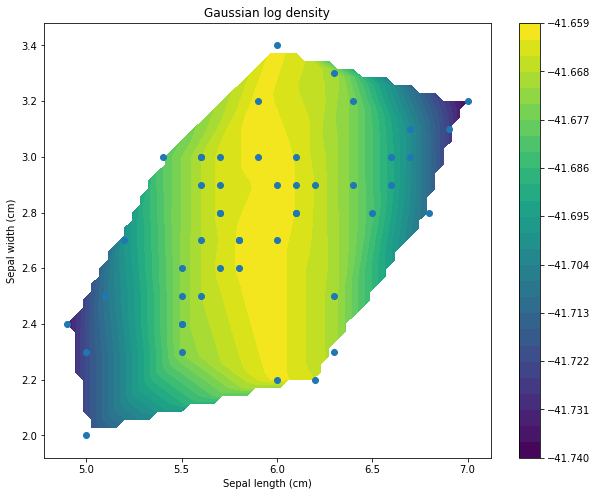

In [135]:
# Instantiate and train the estimator
twoD_param = gaussianDiag(data_2d)
twoD_param.train_diag()

def gaussian_full_density(data_2d):
    density_points = []
    for datapoint in data_2d:
        # Calculate the density at each point
        density_points.append(twoD_param.predict_diag(datapoint))
    return np.array(density_points)

density_points = gaussian_full_density(data_2d)

# Plot the scatter points on top of contour
from matplotlib.mlab import griddata

xi = np.linspace(min(sep_length), max(sep_length))
yi = np.linspace(min(sep_width), max(sep_width))
zi = griddata(sep_length, sep_width, density_points, xi, yi, interp='linear')

plt.contourf(xi, yi, zi, 30)
plt.colorbar();

plt.scatter(sep_length, sep_width)

plt.title('Gaussian log density')
plt.xlabel('Sepal length (cm)')
plt.ylabel('Sepal width (cm)')

plt.show()


### Part (b)

The density estimated by the Parzen estimator, with a $\sigma$ that is too small:

/Users/user/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2. Use scipy.interpolate.griddata instead.
  # This is added back by InteractiveShellApp.init_path()


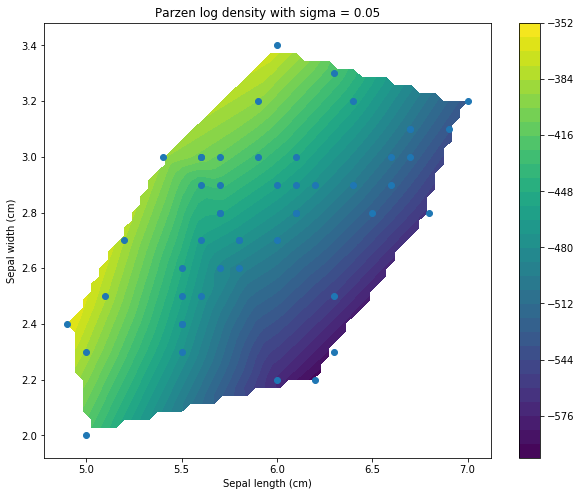

In [136]:
stdev = .05

density_points = parzen_full_density(data_2d, stdev)

def plot_parzen(sep_length, sep_width, density_points, stdev):
    # Plot the scatter points on top of contour
    from matplotlib.mlab import griddata

    xi = np.linspace(min(sep_length), max(sep_length))
    yi = np.linspace(min(sep_width), max(sep_width))
    zi = griddata(sep_length, sep_width, density_points, xi, yi, interp='linear')

    plt.contourf(xi, yi, zi, 30)
    plt.colorbar();

    plt.scatter(sep_length, sep_width)

    plt.title('Parzen log density with sigma = {}'.format(stdev))
    plt.xlabel('Sepal length (cm)')
    plt.ylabel('Sepal width (cm)')

    plt.show()

plot_parzen(sep_length, sep_width, density_points, stdev)

### Part (c)

The density estimated by the Parzen estimator, with a $\sigma$ that is too big:

/Users/user/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2. Use scipy.interpolate.griddata instead.
  # This is added back by InteractiveShellApp.init_path()


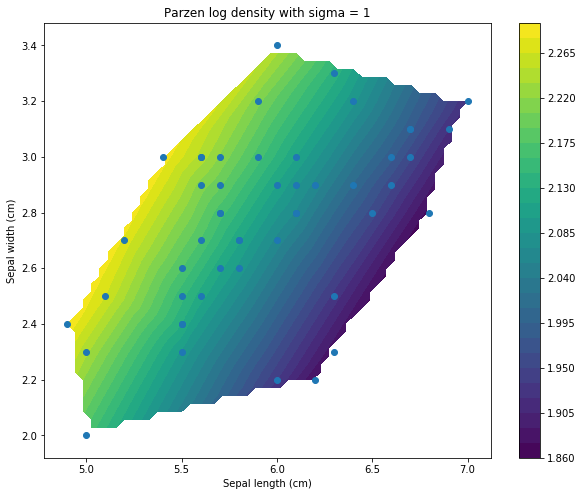

In [137]:
stdev = 1
density_points = parzen_full_density(data_2d, stdev)

plot_parzen(sep_length, sep_width, density_points, stdev)

### Part (d)

The density estimated by the Parzen estimator, with a $\sigma$ that is an appropriate size:

/Users/user/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2. Use scipy.interpolate.griddata instead.
  # This is added back by InteractiveShellApp.init_path()


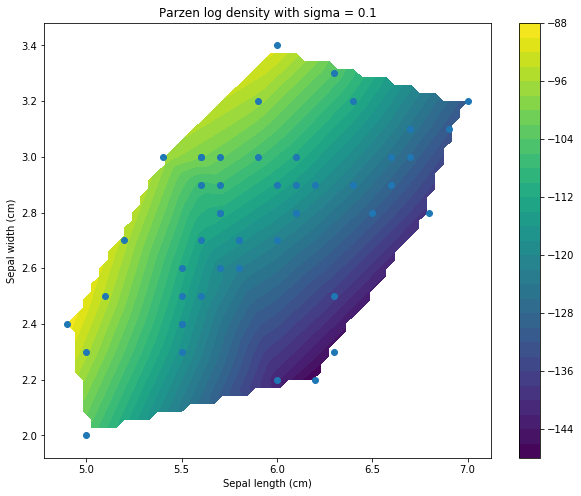

In [138]:
stdev = 0.1
density_points = parzen_full_density(data_2d, stdev)

plot_parzen(sep_length, sep_width, density_points, stdev)

### Part (f)

The hyperparamter $\sigma$ was "tuned" by hand using a similar binary-search-like strategy outlined in Part (f) of Question 3. 0.1 seems to be an acceptable value because it captures more distribution detail than $\sigma = 1$, for example, which only models the main "ridge" of densities shown in yellow and red and simplifies it to a straight line shape, but memorizes less noise than $\sigma = 0.05$, which may be overfitting the "dead spot" shown in blue near the bottom-right of the graph. However, it is worth noting that this choice seems more arbitrary than the tuning done in Question 3. Testing values far below 0.05 to see extreme overfitting may be beneficial, but in this implementation is impossible, due to underflow/divide-by-zero errors.